# Tutorial - Using your own Dataset

In this notebook, we will see how to use your own `Dataset` within `pythae`

In [7]:
# Install the library
%pip install git+https://github.com/clementchadebec/benchmark_VAE.git

  Cloning https://github.com/clementchadebec/benchmark_VAE.git (to revision custom_loaders) to /tmp/pip-req-build-ep0ga262
  Running command git clone -q https://github.com/clementchadebec/benchmark_VAE.git /tmp/pip-req-build-ep0ga262
  Running command git checkout -b custom_loaders --track origin/custom_loaders
  Switched to a new branch 'custom_loaders'
  Branch 'custom_loaders' set up to track remote branch 'custom_loaders' from 'origin'.
  Resolved https://github.com/clementchadebec/benchmark_VAE.git to commit 79c9cf27e85db2b8c509980e276e31b002cc0115
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pythae: filename=pythae-0.0.6-py3-none-any.whl size=202239 sha256=73f9b5385798eedb08c2acfa055394e18b76f8a307a9f13c104261e1c53e39e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-58w8fx6s/wheels/88/07/13/95ada82db6827210c39f7a50de0ce84ae4d8ccc4f7cfcf8001
Successfully built pythae
  Attempti

# Load the data

In [8]:
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:10000].reshape(-1, 1, 28, 28) / 255.
train_targets = mnist_trainset.targets[:10000]
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.
eval_targets = mnist_trainset.targets[-10000:]

## Example
Below is presented an example where we build a dataset inheriting from [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) that iterate on images located in a folder. In particular, this loader will avoid loading all the data at once.

In [10]:
# We will save the data in folders to mimic the desired example

import os
import torch
import numpy as np
import imageio

if not os.path.exists("data_folders"):
    os.mkdir("data_folders")
if not os.path.exists("data_folders/train"):
    os.mkdir("data_folders/train")
if not os.path.exists("data_folders/eval"):
    os.mkdir("data_folders/eval")

for i in range(len(train_dataset)):
    img = 255.0*train_dataset[i][0].unsqueeze(-1)
    img_folder = os.path.join("data_folders", "train", f"{train_targets[i]}")
    if not os.path.exists(img_folder):
        os.mkdir(img_folder)
    imageio.imwrite(os.path.join(img_folder, "%08d.jpg" % i), np.repeat(img, repeats=3, axis=-1).type(torch.uint8))

for i in range(len(eval_dataset)):
    img = 255.0*eval_dataset[i][0].unsqueeze(-1)
    img_folder = os.path.join("data_folders", "eval", f"{eval_targets[i]}")
    if not os.path.exists(img_folder):
        os.mkdir(img_folder)
    imageio.imwrite(os.path.join(img_folder, "%08d.jpg" % i), np.repeat(img, repeats=3, axis=-1).type(torch.uint8))

In [13]:
# Define transforms to be applied on the data when reloaded
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor() # the data must be tensors
])

# Define your `CustomDataset`

In this example, we build a custom dataset inheriting from ImageFolder. The only thing you have to keep in mind when building a custom dataset that you want to use in `pythae` is that the `__getitem__` method must output a `DatasetOutput` instance containing at least `data` as key. If this is not the case, you will not be able to combine your Dataset with the `pipelines`. 

In [14]:
from pythae.data.datasets import DatasetOutput

class MyCustomDataset(datasets.ImageFolder):

    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root=root, transform=transform, target_transform=target_transform)

    def __getitem__(self, index):
        X, _ = super().__getitem__(index)

        return DatasetOutput(
            data=X
        )

In [15]:
train_dataset = MyCustomDataset(
    root="data_folders/train",
    transform=data_transform,
)

eval_dataset = MyCustomDataset(
    root="data_folders/eval", 
    transform=data_transform
)

## Use your CustomDataset to train a `pythae.models`

Now, the datasets can be passed to the `training_pipeline` to train any model implemented in `pythae`.

In [16]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline

In [17]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=10, # Change this to train the model a bit more
)


model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=16
)

model = VAE(
    model_config=model_config
)

In [18]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [19]:
pipeline(
    train_data=train_dataset, # here we use the custom train dataset
    eval_data=eval_dataset # here we use the custom eval dataset
)

Checking train dataset...
Checking eval dataset...
Using Base Trainer

Model passed sanity check !

Created my_model/VAE_training_2022-09-05_09-56-38. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Training of epoch 1/10: 100%|██████████| 100/100 [00:07<00:00, 12.57batch/s]

## Let's have a look to the trained model

In [ ]:
import os
from pythae.models import AutoModel

In [ ]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [ ]:
from pythae.samplers import NormalSampler

In [ ]:
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)

In [ ]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

In [ ]:
import matplotlib.pyplot as plt

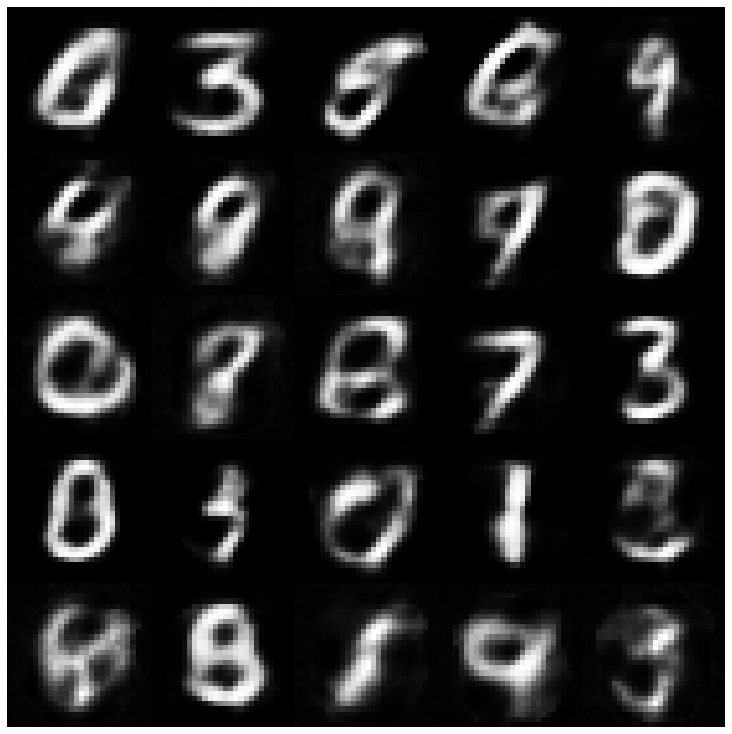

In [ ]:
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)